# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']
midfielder_df = midfielder_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [midfielder_df.columns[i] for i,x in enumerate(midfielder_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
midfielder_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 군집화

### 패스 군집화

In [5]:
from sklearn import cluster
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score

In [6]:
def fit_predict_plot(model,dataset,title):
    x = np.array(dataset)
    model.fit(x)
    if hasattr(model,'label_'):
        labels = model.labels_.astype(np.int)
    else:
        labels = model.predict(x)
        
    colors = np.array(['#30A9DE','#E53A40','#090707','#A593E0','#F6B352','#519D9E','#D81159'])
    
    ax = plt.scatter(x[:,0],x[:,1],color=colors[labels])
    plt.xlabel = '경기당 패스 성공/90'
    plt.ylabel = '경기당 패스 시도/90'

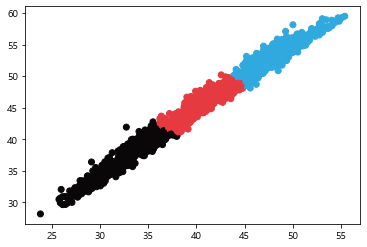

In [7]:
fit_predict_plot(cluster.KMeans(n_clusters=3,random_state=123),list(zip(midfielder_df['경기당 패스 성공/90'],midfielder_df['경기당 패스 시도/90'])),'패스')

k : 2 , score: 45797.9623409887
k : 3 , score: 25329.34380009257
k : 4 , score: 13881.267756561869
k : 5 , score: 10221.635197944956
k : 6 , score: 7206.56639890134
k : 7 , score: 5688.327078235847
k : 8 , score: 4649.279300686357
k : 9 , score: 3883.391847253737


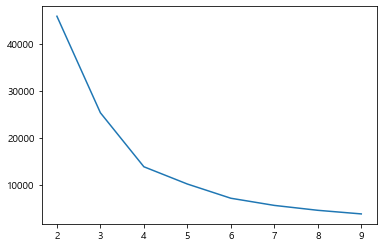

In [8]:
k_range = range(2,10)
inertia_arr = []

for k in k_range:
    kmeans = cluster.KMeans(n_clusters=k,random_state=123)
    kmeans.fit(list(zip(midfielder_df['경기당 패스 성공/90'],midfielder_df['경기당 패스 시도/90'])))
    inertia = kmeans.inertia_

    print(f'k : {k} , score: {inertia}')
    
    inertia_arr.append(inertia)
    
plt.plot(k_range,inertia_arr)

In [9]:
pass_kmeans = cluster.KMeans(n_clusters=3,random_state=123).fit(list(zip(midfielder_df['경기당 패스 성공/90'],midfielder_df['경기당 패스 시도/90'])))

midfielder_df['패스군집'] = pass_kmeans.predict(list(zip(midfielder_df['경기당 패스 성공/90'],midfielder_df['경기당 패스 시도/90'])))

midfielder_df['패스군집_이름'] = midfielder_df['패스군집'].map(lambda x : '안전패스군' if x == 0 else ('일반패스군' if x == 1 else '위험패스군'))

In [10]:
midfielder_df[['이름','패스군집_이름']].query('패스군집_이름 == "위험패스군"')

,이름,패스군집_이름
1,Paul Seguin,위험패스군
2,Julian Green,위험패스군
4,Simon Asta,위험패스군
5,Gian-Luca Itter,위험패스군
7,Jetro Willems,위험패스군
...,...,...
2066,Valerio Verre,위험패스군
2067,Nampalys Mendy,위험패스군
2069,Pervis Estupiñán,위험패스군
2076,Jacopo Sala,위험패스군


In [11]:
independent_value = independent_value - set(['경기당 유효 슈팅/90','경기당 슈팅/90','경기당 패스 성공/90','경기당 패스 시도/90'])
independent_value

{'골',
 '공중볼시도/90',
 '기회 창출/90',
 '달린 거리/90분',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '크로스 성공률',
 '크로스 시도/90',
 '키패스/90',
 '태클 성공/90',
 '태클 성공률',
 '파울 획득',
 '헤더 성공/90'}

In [12]:
safe_pass_df = midfielder_df[midfielder_df['패스군집_이름']=='안전패스군']
normal_pass_df = midfielder_df[midfielder_df['패스군집_이름']=='일반패스군']
danger_pass_df = midfielder_df[midfielder_df['패스군집_이름']=='위험패스군']

# LGBM Regressor 안전패스군 모델 생성

In [32]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold

safe_x_train,safe_x_test,safe_y_train,safe_y_test = train_test_split(safe_pass_df.loc[:,independent_value],safe_pass_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [37]:
midfielder_lgbm = LGBMRegressor()

params = {
    'num_leaves': [7],
    'learning_rate': [0.2],
    'max_depth': [-1],
    'n_estimators': [150],
    'objective' : ["regression"],
    'random_state' :[123],
    'reg_alpha' : [1.4],
    'reg_lambda' : [1.1],
    'subsample': [0.5],
    'extra_trees' : [True]
}


grid = GridSearchCV(midfielder_lgbm, params, scoring='neg_mean_absolute_error', cv=3,refit=True)

grid.fit(safe_pass_df.loc[:,independent_value],
         safe_pass_df.loc[:,dependent_value])

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

-0.30221999292154683
LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=150,
              num_leaves=7, objective='regression', random_state=123,
              reg_alpha=1.4, reg_lambda=1.1, subsample=0.5)
{'extra_trees': True, 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 7, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 1.4, 'reg_lambda': 1.1, 'subsample': 0.5}


In [38]:
safe_midfielder_lgbm = LGBMRegressor(
                num_leaves=7,
                learning_rate=0.2,
                max_depth=-1,
                n_estimators=150,
                objective='regression',
                random_state=123,
                reg_alpha=1.4,
                reg_lambda=1.1,
                subsample=0.5,
                extra_trees=True
                )

In [39]:
safe_midfielder_lgbm.fit(safe_x_train,safe_y_train)

LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=150,
              num_leaves=7, objective='regression', random_state=123,
              reg_alpha=1.4, reg_lambda=1.1, subsample=0.5)

In [40]:
safe_y_pred = safe_midfielder_lgbm.predict(safe_x_test)
mean_absolute_error(safe_y_test,safe_y_pred)

0.3093642566675776

## 모델검정 데이터 삽입

In [63]:
midfielder_df['predict'] = 0

In [45]:
safe_pass_df['predict'] = safe_midfielder_lgbm.predict(safe_pass_df.loc[:,independent_value])

In [62]:
safe_index = safe_pass_df.loc[:,independent_value].index

In [64]:
midfielder_df.loc[safe_index,'predict'] = safe_midfielder_lgbm.predict(safe_pass_df.loc[:,independent_value])

# LGBM Regressor 일반패스군 모델 생성

In [55]:
normal_x_train,normal_x_test,normal_y_train,normal_y_test = train_test_split(normal_pass_df.loc[:,independent_value],normal_pass_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [56]:
midfielder_lgbm = LGBMRegressor()

params = {
    'num_leaves': [5,6,7,8],
    'learning_rate': [0.2],
    'max_depth': [-1],
    'n_estimators': [150],
    'objective' : ["regression"],
    'random_state' :[123],
    'reg_alpha' : [1.1,1.2,1.3,1.4,1.5],
    'reg_lambda' : [1.1,1.2,1.3,1.4,1.5],
    'subsample': [0.5,0.6,0.7,0.8,0.9,1.0],
    'extra_trees' : [True]
}


grid = GridSearchCV(midfielder_lgbm, params, scoring='neg_mean_absolute_error', cv=3,refit=True)

grid.fit(normal_pass_df.loc[:,independent_value],
         normal_pass_df.loc[:,dependent_value])

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

-0.34185902062148954
LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=150,
              num_leaves=5, objective='regression', random_state=123,
              reg_alpha=1.2, reg_lambda=1.5, subsample=0.5)
{'extra_trees': True, 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 5, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 1.2, 'reg_lambda': 1.5, 'subsample': 0.5}


In [58]:
normal_midfielder_lgbm = LGBMRegressor(
                num_leaves=5,
                learning_rate=0.2,
                max_depth=-1,
                n_estimators=150,
                objective='regression',
                random_state=123,
                reg_alpha=1.2,
                reg_lambda=1.5,
                subsample=0.5,
                extra_trees=True
                )

In [59]:
normal_midfielder_lgbm.fit(normal_x_train,normal_y_train)

LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=150,
              num_leaves=5, objective='regression', random_state=123,
              reg_alpha=1.2, reg_lambda=1.5, subsample=0.5)

In [67]:
normal_y_pred = normal_midfielder_lgbm.predict(normal_x_test)
mean_absolute_error(normal_y_test,normal_y_pred)

0.3580015176787896

In [68]:
normal_pass_df['predict'] = normal_midfielder_lgbm.predict(normal_pass_df.loc[:,independent_value])

In [69]:
normal_index = normal_pass_df.loc[:,independent_value].index

In [70]:
midfielder_df.loc[normal_index,'predict'] = normal_midfielder_lgbm.predict(normal_pass_df.loc[:,independent_value])

# 위험 패스군 모델 생성

In [71]:
danger_x_train,danger_x_test,danger_y_train,danger_y_test = train_test_split(danger_pass_df.loc[:,independent_value],danger_pass_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [72]:
midfielder_lgbm = LGBMRegressor()

params = {
    'num_leaves': [5,6,7,8],
    'learning_rate': [0.2],
    'max_depth': [-1],
    'n_estimators': [150],
    'objective' : ["regression"],
    'random_state' :[123],
    'reg_alpha' : [1.1,1.2,1.3,1.4,1.5],
    'reg_lambda' : [1.1,1.2,1.3,1.4,1.5],
    'subsample': [0.5,0.6,0.7,0.8,0.9,1.0],
    'extra_trees' : [True]
}


grid = GridSearchCV(midfielder_lgbm, params, scoring='neg_mean_absolute_error', cv=3,refit=True)

grid.fit(danger_pass_df.loc[:,independent_value],
         danger_pass_df.loc[:,dependent_value])

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

-0.3409490426516031
LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=150,
              num_leaves=8, objective='regression', random_state=123,
              reg_alpha=1.3, reg_lambda=1.5, subsample=0.5)
{'extra_trees': True, 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 8, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 1.3, 'reg_lambda': 1.5, 'subsample': 0.5}


In [73]:
danger_midfielder_lgbm = LGBMRegressor(
                num_leaves=8,
                learning_rate=0.2,
                max_depth=-1,
                n_estimators=150,
                objective='regression',
                random_state=123,
                reg_alpha=1.3,
                reg_lambda=1.5,
                subsample=0.5,
                extra_trees=True
                )

In [74]:
danger_midfielder_lgbm.fit(danger_x_train,danger_y_train)

LGBMRegressor(extra_trees=True, learning_rate=0.2, n_estimators=150,
              num_leaves=8, objective='regression', random_state=123,
              reg_alpha=1.3, reg_lambda=1.5, subsample=0.5)

In [75]:
danger_y_pred = danger_midfielder_lgbm.predict(danger_x_test)
mean_absolute_error(danger_y_test,danger_y_pred)

0.34494784868127293

In [76]:
danger_pass_df['predict'] = danger_midfielder_lgbm.predict(danger_pass_df.loc[:,independent_value])

In [77]:
danger_index = danger_pass_df.loc[:,independent_value].index

In [78]:
midfielder_df.loc[danger_index,'predict'] = danger_midfielder_lgbm.predict(danger_pass_df.loc[:,independent_value])

In [118]:
import joblib

joblib.dump(midfielder_lgbm, './models/midfielder_lgbm_cluster.pkl')

['./models/midfielder_lgbm_cluster.pkl']

## 선형성 검정

In [79]:
residual = midfielder_df['평균획득승점/경기'] - midfielder_df['predict']

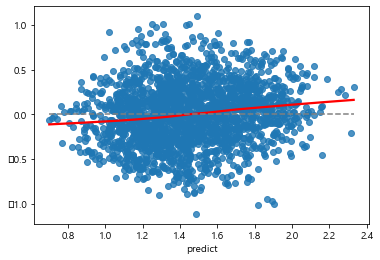

In [80]:
sns.regplot(midfielder_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([midfielder_df['predict'].values.min(), midfielder_df['predict'].values.max()], [0, 0], '--', color='grey')

## 잔차의 정규성 검정

In [81]:
# 정규성 불만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9991351366043091, pvalue=0.4325277805328369)

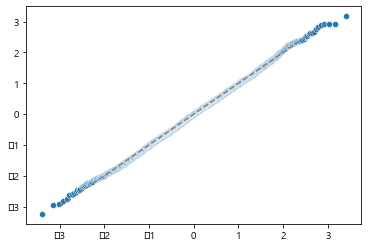

In [82]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

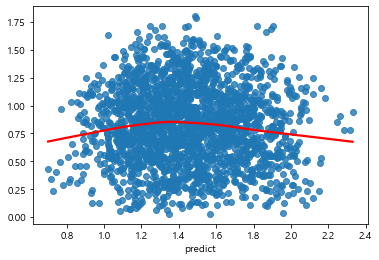

In [83]:
sns.regplot(midfielder_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [85]:
# 등분산성 불만족
stats.levene(midfielder_df['평균획득승점/경기'],midfielder_df['predict'])

LeveneResult(statistic=573.4410868826591, pvalue=7.151551695472934e-119)

## 잔차의 독립성 검정

In [87]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

0.9482314241773196

In [86]:
mean_absolute_error(midfielder_df['평균획득승점/경기'],midfielder_df['predict'])

0.27624560242544666